In [1]:
pwd

'/media/bigdata/projects/pytau/pytau/how_to/notebooks'

# Deal with paths

In [2]:
# Write to MODEL_SAVE_DIR.params
import os
# Use relative paths that work in any environment
# Find the pytau root directory by looking for pyproject.toml
current_dir = os.getcwd()
pytau_base_dir = current_dir
while not os.path.exists(os.path.join(pytau_base_dir, 'pyproject.toml')):
    parent = os.path.dirname(pytau_base_dir)
    if parent == pytau_base_dir:  # reached root
        pytau_base_dir = current_dir  # fallback to current dir
        break
    pytau_base_dir = parent

param_file_path = os.path.join(pytau_base_dir, 'pytau', 'config', 'MODEL_SAVE_DIR.params')
save_model_path = os.path.join(pytau_base_dir, 'pytau', 'how_to', 'examples', 'saved_models')

# Create directories if they don't exist
os.makedirs(os.path.dirname(param_file_path), exist_ok=True)
os.makedirs(save_model_path, exist_ok=True)

with open(param_file_path, 'w') as f:
    f.write(save_model_path)

print(f'Using directory: {save_model_path}')

# Imports

In [3]:
import pylab as plt
from scipy import stats
import tables
import os
from glob import glob
import numpy as np
import sys
sys.path.append(pytau_base_dir)
from pytau.utils import plotting
from pytau.changepoint_model import single_taste_poisson, advi_fit
from pytau.changepoint_preprocess import preprocess_single_taste

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Using directory: /media/bigdata/projects/pytau//pytau/how_to/examples/saved_models


In [4]:
# Find hf5 file
h5_path_list = glob(os.path.join(pytau_base_dir, '**', 'AM*.h5'), recursive=True)

# Find or Download data

In [5]:
download_script_path = os.path.join(pytau_base_dir, 'pytau/how_to/scripts/download_test_data.sh')
if not len(h5_path_list):
    os.system(f'bash {download_script_path}')
    h5_path = glob(os.path.join(pytau_base_dir, '**', 'AM*.h5'), recursive=True)[0]
else:
    h5_path = h5_path_list[0]

In [6]:
h5_path

'/media/bigdata/projects/pytau/pytau/how_to/test_data/AM11_4Tastes_191030_114043_spike_trains_only/AM11_4Tastes_191030_114043_minimal.h5'

# Load Spike Train

In [7]:
wanted_dig_in_ind = 0
with tables.open_file(h5_path,'r') as hf5:
    dig_in_list = hf5.list_nodes('/spike_trains')
    wanted_dig_in = dig_in_list[wanted_dig_in_ind]
    spike_train = wanted_dig_in.spike_array[:]

In [8]:
spike_train.shape

(30, 35, 7000)

In [9]:
# Bin Spike Train

In [10]:
time_lims = [2000, 4000]
bin_width = 50
binned_spike_array = preprocess_single_taste(
    spike_array=spike_train,
    time_lims=time_lims,
    bin_width=bin_width,
    data_transform=None)

In [11]:
binned_spike_array.shape

(30, 35, 40)

# Infer Changepoints

In [12]:
# Create and fit model
n_fit = 40000
n_samples = 20000
n_states = 4
model = single_taste_poisson(binned_spike_array, n_states)
model, approx, lambda_stack, tau_samples, fit_data = \
        advi_fit(model = model, fit = n_fit, samples = n_samples)

Finished [100%]: Average Loss = 22,156


In [13]:
# Extract changepoint values
int_tau = np.vectorize(int)(tau_samples)
mode_tau = np.squeeze(stats.mode(int_tau, axis=0)[0])
# Ensure mode_tau is 1D array of changepoints
if mode_tau.ndim == 0:
    mode_tau = np.array([mode_tau])
# Scale the changepoints
scaled_changepoints = (mode_tau*bin_width)+time_lims[0]
# Replicate changepoints for each trial to match plotting function expectations
# spike_train has shape (n_trials, n_neurons, n_bins), so we need (n_trials, n_changepoints)
n_trials = spike_train.shape[0]
scaled_mode_tau = np.tile(scaled_changepoints, (n_trials, 1))

In [14]:
mode_tau

array([[33, 34, 35],
       [17, 18, 18],
       [25, 26, 27],
       [20, 21, 21],
       [22, 24, 38],
       [ 3, 14, 15],
       [12, 20, 25],
       [14, 18, 20],
       [ 8, 21, 24],
       [13, 29, 32],
       [ 6, 21, 22],
       [ 4, 19, 20],
       [ 8, 11, 13],
       [ 1, 29, 38],
       [16, 18, 38],
       [10, 21, 38],
       [ 5,  7, 27],
       [10, 12, 38],
       [ 9, 15, 30],
       [ 7,  9, 38],
       [ 2, 12, 34],
       [ 8, 18, 38],
       [ 1, 13, 22],
       [ 0, 27, 29],
       [18, 20, 34],
       [ 7, 18, 19],
       [ 2, 22, 24],
       [ 1, 31, 36],
       [ 1, 22, 38],
       [ 0, 36, 38]])

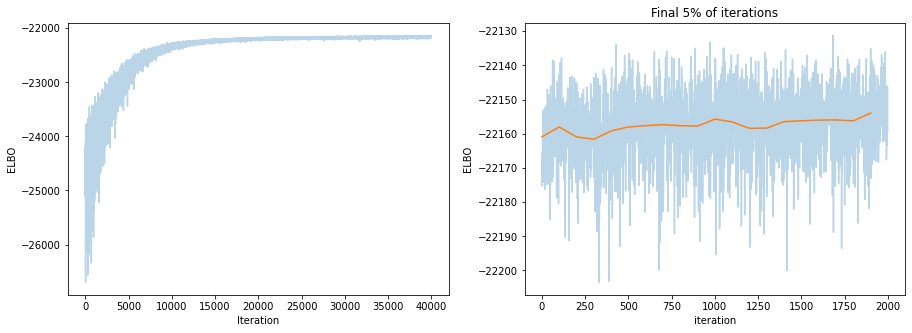

In [15]:
# Plot ELBO over iterations, should be flat by the end
fig, ax = plotting.plot_elbo_history(approx)
plt.show()

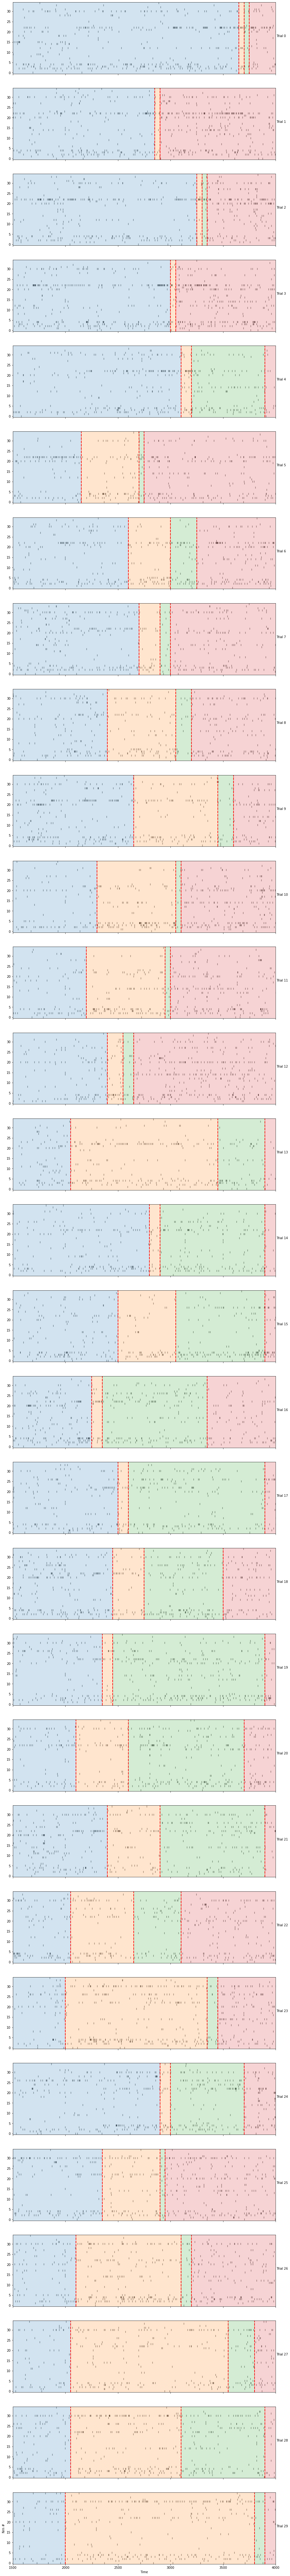

In [16]:
# Overlay raster plot with states
fig, ax = plotting.plot_changepoint_raster(
    spike_train, scaled_mode_tau, [1500, 4000])
plt.show()

/media/bigdata/projects/pytau/pytau/utils/plotting.py:119: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(np.arange(plot_lims[1]), np.arange(n_trials), state_durations)


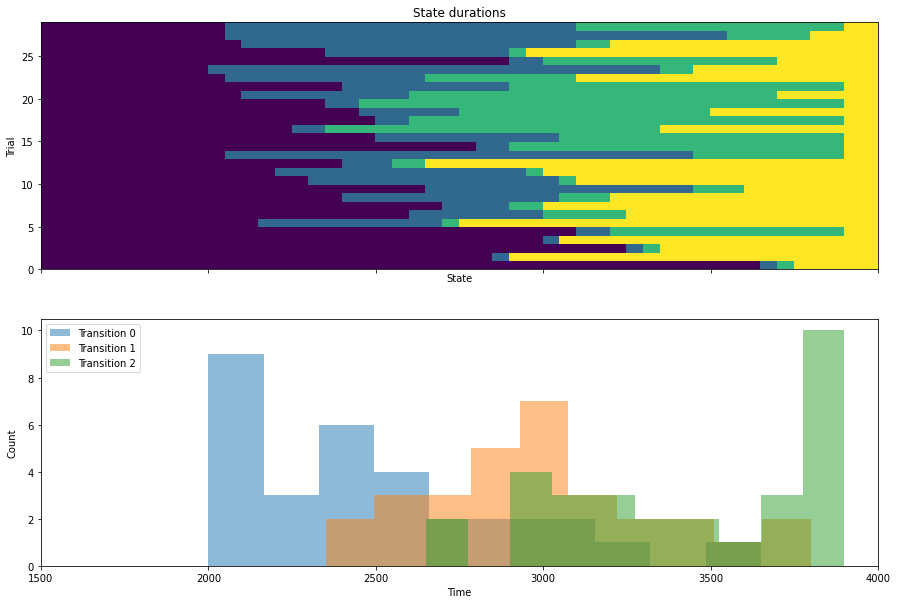

In [17]:
# Overview of changepoint positions
fig, ax = plotting.plot_changepoint_overview(scaled_mode_tau, [1500, 4000])
plt.show()

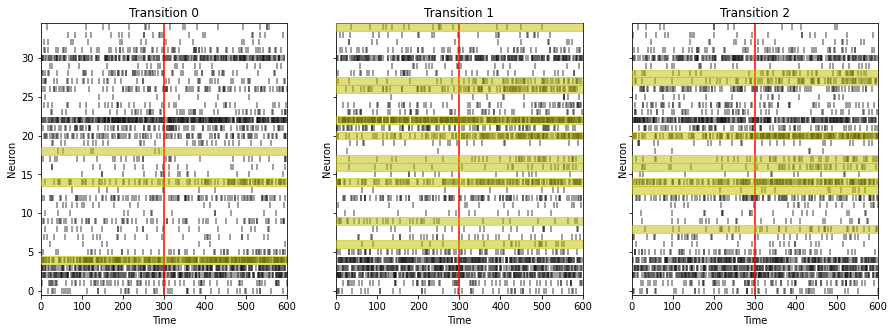

In [18]:
# Aligned spiking
fig, ax = plotting.plot_aligned_state_firing(spike_train, scaled_mode_tau, 300)
plt.show()

/home/abuzarmahmood/anaconda3/envs/pytau_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


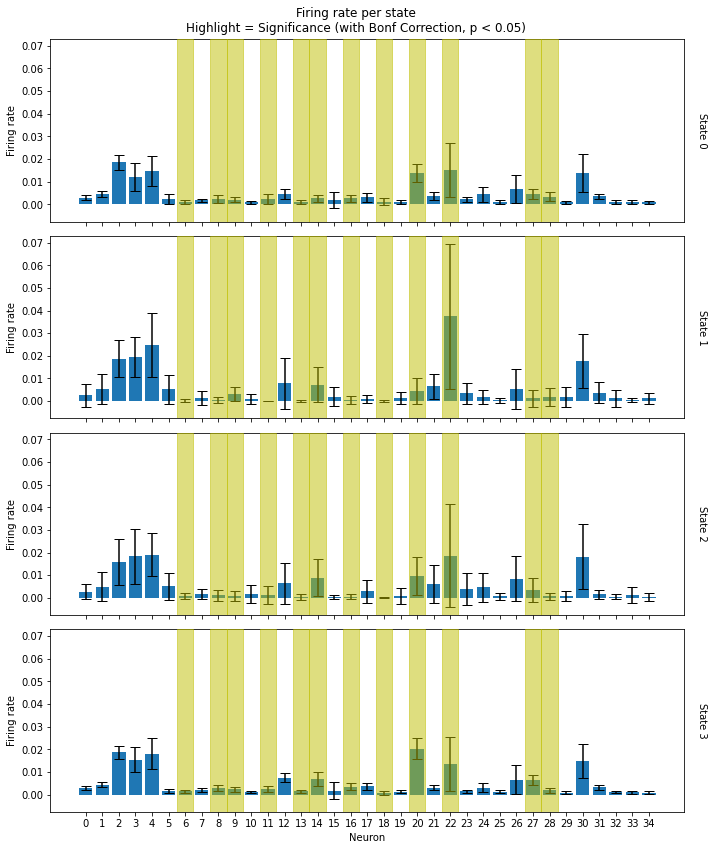

In [19]:
# Plot mean firing rates per state
fig, ax = plotting.plot_state_firing_rates(spike_train, scaled_mode_tau)
plt.show()